## Objective: Implement RNN, LSTM , GRU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import time
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm import tqdm

c:\Users\Admin\Desktop\codes\AI-ML-Implementations\ml-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Dataset

In [3]:
ds = load_dataset("stanfordnlp/imdb")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [5]:
def process_data(data,max_length=500):
    texts = []
    labels = []

    for row in tqdm(data):
        tokens = tokenizer.encode(row['text'])
        if len(tokens) < max_length:
            tokens = tokens + [0] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        texts.append(tokens)
        labels.append(row['label'])
    
    return torch.tensor(texts) , torch.tensor(labels)


x_train , y_train = process_data(ds['train'])
x_test , y_test = process_data(ds['test'])

100%|██████████| 25000/25000 [00:10<00:00, 2337.60it/s]


In [6]:
batch_size = 64

train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 25000, Test samples: 25000


In [7]:
print(f"Train labels distribution: {y_train.float().mean().item():.2%} positive")
print(f"Test labels distribution: {y_test.float().mean().item():.2%} positive")

Train labels distribution: 50.00% positive
Test labels distribution: 50.00% positive


### Models

In [24]:
class RNNModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_layers=-1,dropout=0.2):
        super(RNNModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.rnn = nn.RNN(embedding_dim,hidden_dim,num_layers=num_layers,batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim,1)

    def forward(self,x):
        embedded = self.embedding(x)
        output , hidden = self.rnn(embedded)
        res = self.dropout(output.mean(dim=1) )
        return torch.sigmoid(self.fc(res)).squeeze()


In [25]:
class LSTMModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_layers=-1,dropout=0.2):
        super(LSTMModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim,hidden_dim,num_layers=num_layers,batch_first=True,dropout=dropout if num_layers > 1 else 0,
                           bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim,1)

    def forward(self,x):
        embedded = self.embedding(x)
        output , (hidden,cell) = self.rnn(embedded)
        res = self.dropout(output.mean(dim=1) )
        return torch.sigmoid(self.fc(res)).squeeze()


In [26]:
class GRUModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_layers=-1,dropout=0.2):
        super(GRUModel,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.rnn = nn.GRU(embedding_dim,hidden_dim,num_layers=num_layers,
                           batch_first=True,dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim,1)

    def forward(self,x):
        embedded = self.embedding(x)
        output , hidden = self.rnn(embedded)
        res = self.dropout(output.mean(dim=1) )
        return torch.sigmoid(self.fc(res)).squeeze()

## Evaluate

In [27]:
def train_model(model,train_loader,test_loader,epochs=10,model_name='Model'):
    model.to(device)
    loss_func = nn.BCELoss() #Binary Cross Entropy loss = -log(p) or -log(1-p)
    optimizer = optim.Adam(model.parameters(),lr=0.001)

    train_losses = []
    test_accuracies = []

    print(f"\nTraining {model_name}...")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx , (texts,labels) in enumerate(train_loader):
            texts , labels = texts.to(device) , labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(texts)
            loss = loss_func(outputs,labels)
            loss.backward()

                                           
            optimizer.step()

            total_loss += loss.item()
           
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = total = 0

        with torch.no_grad():
            for texts , labels in test_loader:
                texts , labels = texts.to(device) , labels.to(device).float()
                outputs = model(texts)
                predictions = (outputs > 0.5).float()
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return train_losses, test_accuracies, training_time

In [28]:
vocab_size = tokenizer.vocab_size
embedding_dim = 128
hidden_dim = 64
num_layers = 2
print(vocab_size)

28996


In [29]:
models = {
    "RNN": RNNModel(vocab_size, embedding_dim, hidden_dim, num_layers),
    "LSTM": LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers),
    "GRU": GRUModel(vocab_size, embedding_dim, hidden_dim, num_layers)
}

In [30]:
results = {}
epochs = 20

for name, model in models.items():
    print(f"\n{name} Model Architecture:")
    print(model)
    
    train_losses, test_accuracies, training_time = train_model(
        model, train_loader, test_loader, epochs=epochs, model_name=name
    )
    
    results[name] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'training_time': training_time
    }


RNN Model Architecture:
RNNModel(
  (embedding): Embedding(28996, 128, padding_idx=0)
  (rnn): RNN(128, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Training RNN...
Epoch 1/20, Loss: 0.5832, Test Accuracy: 77.54%
Epoch 2/20, Loss: 0.5514, Test Accuracy: 70.70%
Epoch 3/20, Loss: 0.5040, Test Accuracy: 75.67%
Epoch 4/20, Loss: 0.5047, Test Accuracy: 65.11%
Epoch 5/20, Loss: 0.7219, Test Accuracy: 77.12%
Epoch 6/20, Loss: 0.5661, Test Accuracy: 79.43%
Epoch 7/20, Loss: 0.4980, Test Accuracy: 69.47%
Epoch 8/20, Loss: 0.4742, Test Accuracy: 77.66%
Epoch 9/20, Loss: 0.4441, Test Accuracy: 67.04%
Epoch 10/20, Loss: 0.6552, Test Accuracy: 49.78%
Epoch 11/20, Loss: 0.6963, Test Accuracy: 59.20%
Epoch 12/20, Loss: 0.6546, Test Accuracy: 66.58%
Epoch 13/20, Loss: 0.5738, Test Accuracy: 72.90%
Epoch 14/20, Loss: 0.5091, Test Accuracy: 74.03%
Epoch 15/20, Loss: 0.5336, Test Accuracy: 73.54%
Epoch 16/20, 

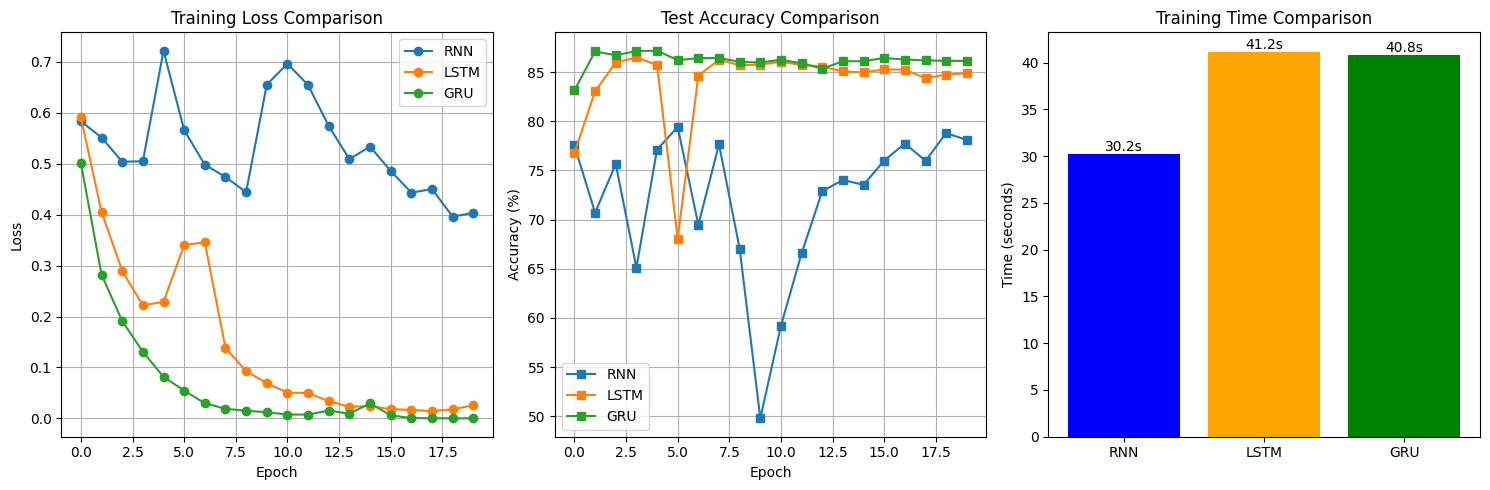

In [32]:
plt.figure(figsize=(15, 5))

# Plot training losses
plt.subplot(1, 3, 1)
for name in models.keys():
    plt.plot(results[name]['train_losses'], label=name, marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test accuracies
plt.subplot(1, 3, 2)
for name in models.keys():
    plt.plot(results[name]['test_accuracies'], label=name, marker='s')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
times = [results[name]['training_time'] for name in models.keys()]
bars = plt.bar(models.keys(), times, color=['blue', 'orange', 'green'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()
